In [2]:
import importlib
from utils.raster import (
    read_raster,
    plot_raster,
    downscale_raster,
)

In [3]:
HAND_DEPTH_FILE = "./data/raw/input/2year_12090301_depth.tif"
OUTPUT_RASTER = "./data/raw/output/fim_2year.tif"
OUTPUT_RASTER_DS = "./data/raw/output/fim_2year_downscaled.tif"

In [4]:
image,meta = read_raster(HAND_DEPTH_FILE)
print("HAND RASTER SHAPE:", image.shape)
print("HAND RASTER META:", meta)

HAND RASTER SHAPE: (10217, 13723)
HAND RASTER META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 13723, 'height': 10217, 'count': 1, 'crs': CRS.from_epsg(5070), 'transform': Affine(10.0, 0.0, -175264.92445121676,
       0.0, -10.0, 831329.9641075488), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


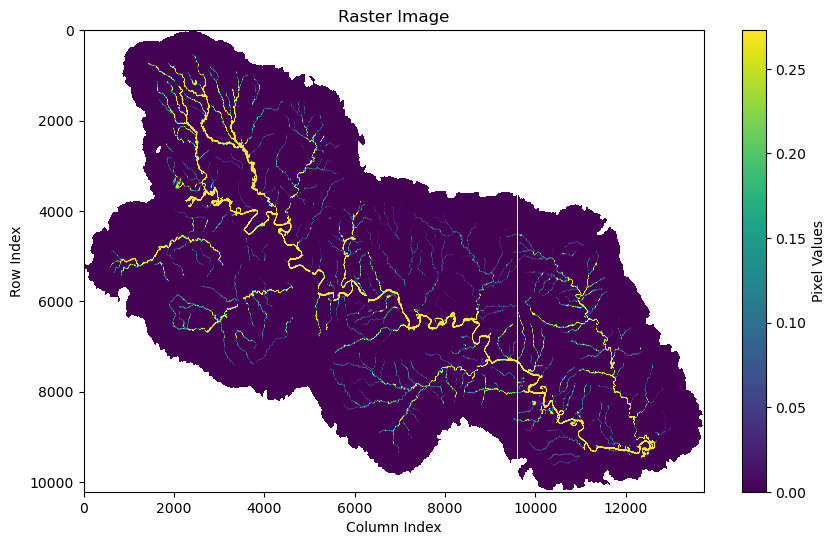

In [4]:
plot_raster(image, nodata=meta['nodata'])

In [8]:
image_output,meta = read_raster(OUTPUT_RASTER)
print("HAND RASTER SHAPE:", image_output.shape)
print("HAND RASTER META:", meta)

HAND RASTER SHAPE: (30509, 41808)
HAND RASTER META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 41808, 'height': 30509, 'count': 1, 'crs': CRS.from_epsg(5070), 'transform': Affine(3.0, 0.0, -169930.8646153165,
       0.0, -3.0, 826303.7172132805), 'blockysize': 1, 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}


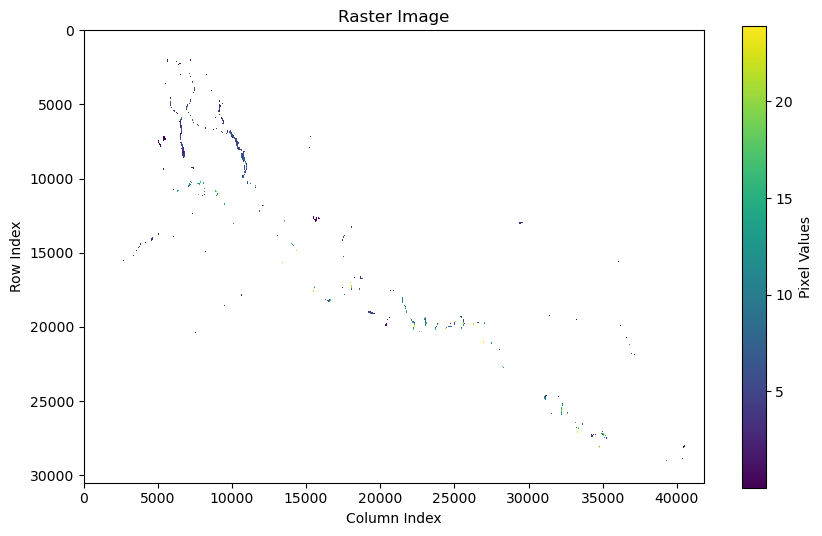

In [6]:
plot_raster(image_output, nodata=meta['nodata'])

In [10]:
max(image_output.reshape(-1))

358.4306

In [6]:
downscale_raster(
    input_path=OUTPUT_RASTER,
    output_path=OUTPUT_RASTER_DS,
    target_width=13723,
    target_height=10217
)

In [7]:
out_down_img, out_down_meta = read_raster(OUTPUT_RASTER_DS)
print("OUT RASTER SHAPE:", out_down_img.shape)
print("OUT RASTER META:", out_down_meta)

OUT RASTER SHAPE: (10217, 13723)
OUT RASTER META: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 13723, 'height': 10217, 'count': 1, 'crs': CRS.from_epsg(5070), 'transform': Affine(9.13969248706551, 0.0, -169930.8646153165,
       0.0, -8.958304786140747, 826303.7172132805), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


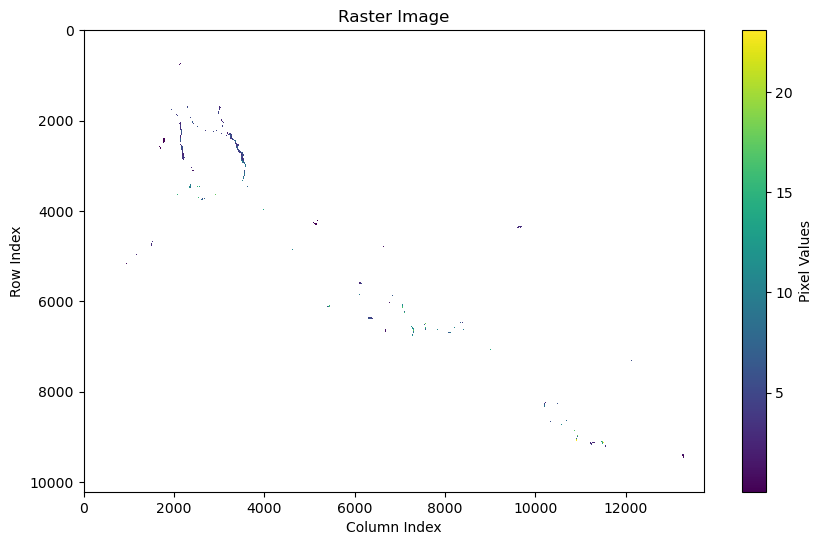

In [10]:
plot_raster(out_down_img, nodata=out_down_meta['nodata'])

In [11]:
print("INPUT SHAPE: ", image.shape)

INPUT SHAPE:  (10217, 13723)


In [12]:
print("OUTPUT SHAPE: ", out_down_img.shape)

OUTPUT SHAPE:  (10217, 13723)


In [14]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Flatten input and target
X = image.flatten().reshape(-1, 1)
y = out_down_img.flatten()

# Mask out nodata values (assuming -9999)
mask = np.isfinite(X[:, 0]) & np.isfinite(y)
mask &= (X[:, 0] != -9999) & (y != -9999)

X_valid = X[mask]
y_valid = y[mask]

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_valid, y_valid, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBRegressor(n_estimators=400, max_depth=5, learning_rate=0.1)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 5.9773
R²: 0.0104


/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


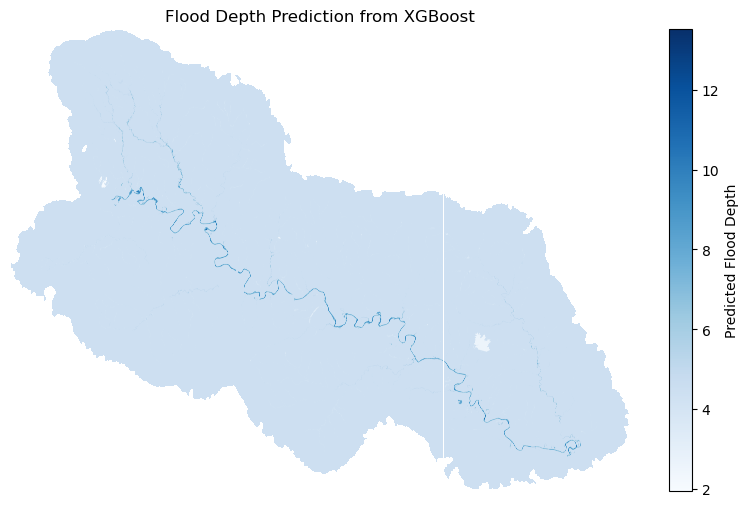

In [15]:
import matplotlib.pyplot as plt
import numpy.ma as ma

# Step 1: Flatten and mask
flat_image = image.flatten()
mask = (flat_image != -9999) & np.isfinite(flat_image)

# Step 2: Prepare input for prediction
X_full = flat_image[mask].reshape(-1, 1)

# Step 3: Predict with trained model
y_pred_full = model.predict(X_full)

# Step 4: Fill predictions into 2D shape
pred_raster = np.full_like(flat_image, fill_value=np.nan, dtype=np.float32)
pred_raster[mask] = y_pred_full
pred_raster = pred_raster.reshape(image.shape)

# Step 5: Mask nodata for plotting
masked_pred = ma.masked_invalid(pred_raster)

# Step 6: Plot
plt.figure(figsize=(10, 6))
plt.imshow(masked_pred, cmap='Blues')
plt.colorbar(label='Predicted Flood Depth')
plt.title("Flood Depth Prediction from XGBoost")
plt.axis('off')
plt.show()fdsf
